# {ticker} Stock Analysis using IDX Momentum Indicator
## Indonesian Stock Market Scalping Strategy
**Based on Order Flow Analysis + Broker Action + Multi-day Accumulation**

Analysis Date: February 10, 2026

⚠️ Edit the `ticker` variable in Cell 2 to analyze any Indonesian stock

## Section 1: Import Libraries and Load Data

In [55]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add path to import IDXMomentumIndicator
sys.path.insert(0, '/Users/cevin/Documents/QuantResearch/docs')
from idx_momentum_indicator import IDXMomentumIndicator

print("✓ Libraries imported successfully")
print(f"✓ IDXMomentumIndicator ready for analysis")

✓ Libraries imported successfully
✓ IDXMomentumIndicator ready for analysis


In [ ]:
# Fetch PPRE historical data from yfinance
ticker = 'PANI'
ticker_formatted = f"{ticker}.JK"

print(f"📊 Fetching {ticker} historical data...")
try:
    ppre_data = yf.download(ticker_formatted, period="max", progress=False)
    print(f"✓ Downloaded {len(ppre_data)} records")
    print(f"  Date range: {ppre_data.index.min().date()} to {ppre_data.index.max().date()}")
    
    # Display recent data
    print(f"\n📈 Recent {ticker} Price Data (Last 10 days):")
    print(ppre_data[['Close', 'Volume']].tail(10))
    
    current_price = ppre_data['Close'].iloc[-1]
    print(f"\n💰 Current Price: IDR {current_price:.0f}")
    
except Exception as e:
    print(f"⚠ Error fetching data: {e}")

📊 Fetching PANI historical data...
✓ Downloaded 1807 records
  Date range: 2018-09-18 to 2026-02-10

📈 Recent PPRE Price Data (Last 10 days):
Price         Close    Volume
Ticker      PANI.JK   PANI.JK
Date                         
2026-01-28   9575.0  36199400
2026-01-29   9200.0  44079600
2026-01-30   9300.0  13822300
2026-02-02   7925.0  34043300
2026-02-03   8900.0  17825400
2026-02-04   8900.0   9199600
2026-02-05   8800.0   4935000
2026-02-06   8925.0   9173200
2026-02-09   9850.0  24512800
2026-02-10  10900.0  32671200
⚠ Error fetching data: unsupported format string passed to Series.__format__


## Section 2: Initialize IDX Momentum Indicator

In [ ]:
# Initialize the indicator with custom thresholds
indicator = IDXMomentumIndicator(thresholds={
    'large_volume': 50000,              # Large HAKA/HAKI volume threshold
    'accumulation_confidence': 75,       # Confidence score for accumulation
    'distribution_confidence': 80,       # Confidence score for distribution
    'min_multi_day': 2,                  # Minimum positive days for accumulation
})

print("=" * 80)
print("IDX MOMENTUM INDICATOR - CONFIGURATION")
print("=" * 80)
print(f"\n📋 Configured Thresholds:")
for key, value in indicator.thresholds.items():
    print(f"   {key}: {value}")

print(f"\n✓ Indicator initialized and ready for {ticker} analysis")

IDX MOMENTUM INDICATOR - CONFIGURATION

📋 Configured Thresholds:
   large_volume: 50000
   accumulation_confidence: 75
   distribution_confidence: 80
   min_multi_day: 2

✓ Indicator initialized and ready for PPRE analysis


## Section 3: Fetch Live Order Book from API

**Real-time Market Microstructure Data:**
- Bid prices/volumes/frequencies: **LIVE from datasaham.io API**
- Ask prices/volumes/frequencies: **LIVE from datasaham.io API**
- HAKA volume: Foreign aggressive buy volume (from API)
- HAKI volume: Foreign aggressive sell volume (from API)
- Net flow data: 3-day broker flow summary (from API)

→ All data is **REAL TIME** fetched directly from `/api/emiten/{SYMBOL}/orderbook`

In [ ]:
# FETCH PPRE ORDER BOOK FROM LIVE API
import requests

api_key = "sbk_b0df044971dab991ddb075caf87b8df83ad0fbd2d67d3a92"
base_url = "https://api.datasaham.io/api/emiten"

def fetch_live_orderbook(symbol):
    """Fetch real order book from API"""
    url = f"{base_url}/{symbol}/orderbook"
    headers = {'x-api-key': api_key}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error: {e}")
        return None

# Fetch order book from API
print(f"🔄 Fetching {ticker} order book from datasaham.io API...")
api_data = fetch_live_orderbook(ticker)

if api_data and api_data.get('success'):
    ob = api_data['data']
    
    # Extract BID data from API (convert from shares to lots: 1 lot = 100 shares)
    ppre_bid_prices = [int(b['price']) for b in ob['bid'][:10]]
    ppre_bid_volumes = [int(b['volume']) / 100 for b in ob['bid'][:10]]
    ppre_bid_freqs = [int(b['que_num']) for b in ob['bid'][:10]]
    
    # Extract ASK/OFFER data from API (convert from shares to lots: 1 lot = 100 shares)
    ppre_ask_prices = [int(a['price']) for a in ob['offer'][:10]]
    ppre_ask_volumes = [int(a['volume']) / 100 for a in ob['offer'][:10]]
    ppre_ask_freqs = [int(a['que_num']) for a in ob['offer'][:10]]
    
    # Extract broker activity from API (convert from shares to lots)
    ppre_current_price = int(ob['lastprice'])
    ppre_bid_ask_spread = ppre_ask_prices[0] - ppre_bid_prices[0]
    ppre_haka_volume = int(ob['fbuy']) / 100  # Foreign aggressive buy (in lots)
    ppre_haki_volume = int(ob['fsell']) / 100  # Foreign aggressive sell (in lots)
    ppre_fnet = int(ob['fnet']) / 100  # Foreign net flow (in lots)
    
    print(f"✅ Live data loaded: {ob['name']} ({ob['symbol']})")
else:
    print("❌ Failed to fetch API data - using fallback simulated data")
    ppre_bid_prices = [200, 199, 198, 197, 196]
    ppre_bid_volumes = [450, 380, 520, 280, 340]  # in lots
    ppre_bid_freqs = [120, 95, 110, 78, 65]
    ppre_ask_prices = [201, 202, 203, 204, 205]
    ppre_ask_volumes = [550, 420, 480, 350, 400]  # in lots
    ppre_ask_freqs = [130, 105, 98, 85, 75]
    ppre_current_price = 200
    ppre_bid_ask_spread = 1
    ppre_haka_volume = 650  # in lots
    ppre_haki_volume = 550  # in lots
    ppre_fnet = 100  # in lots

# Calculate 3-day net flow (using current fnet as proxy for recent trend)
ppre_net_flow_3days = [ppre_fnet / 1e6, ppre_fnet / 1e6 * 0.8, ppre_fnet / 1e6 * 0.6]

# Create order book summary
print("=" * 80)
print(f"{ticker} ORDER BOOK SNAPSHOT - Current Microstructure (in LOTS)")
print("=" * 80)

# Create DataFrame for better visualization
bid_df = pd.DataFrame({
    'Level': range(1, 11),
    'Bid Price': ppre_bid_prices,
    'Bid Volume (Lots)': [f"{int(v):,}" for v in ppre_bid_volumes],
    'Bid Freq': ppre_bid_freqs
})

ask_df = pd.DataFrame({
    'Level': range(1, 11),
    'Ask Price': ppre_ask_prices,
    'Ask Volume (Lots)': [f"{int(v):,}" for v in ppre_ask_volumes],
    'Ask Freq': ppre_ask_freqs
})

print("\n📊 BID SIDE (Buyers):")
print(bid_df.to_string(index=False))

print("\n\n📊 ASK SIDE (Sellers):")
print(ask_df.to_string(index=False))

print(f"\n💰 Market Info:")
print(f"   Current Price: IDR {ppre_current_price}")
print(f"   Bid-Ask Spread: {ppre_bid_ask_spread} IDR ({(ppre_bid_ask_spread/ppre_current_price)*100:.2f}%)")
print(f"   Total Bid Volume: {int(sum(ppre_bid_volumes)):,} lots")
print(f"   Total Ask Volume: {int(sum(ppre_ask_volumes)):,} lots")
print(f"   Volume Ratio (Ask/Bid): {sum(ppre_ask_volumes)/sum(ppre_bid_volumes):.2f}x")

print(f"\n🔥 Aggressive Volume:")
print(f"   HAKA (Aggressive Buy): {int(ppre_haka_volume):,} lots")
print(f"   HAKI (Aggressive Sell): {int(ppre_haki_volume):,} lots")
print(f"   Net Aggressive: {'BUY' if ppre_haka_volume > ppre_haki_volume else 'SELL'}")

print(f"\n📈 Broker 3-Day Net Flow: {ppre_net_flow_3days} (Millions IDR)")


🔄 Fetching PPRE order book from datasaham.io API...
✅ Live data loaded: PP Presisi Tbk. (PPRE)
PPRE ORDER BOOK SNAPSHOT - Current Microstructure (in LOTS)

📊 BID SIDE (Buyers):
 Level  Bid Price Bid Volume (Lots)  Bid Freq
     1        206             2,631        24
     2        204            15,000        56
     3        202            22,152       107
     4        200            49,512       283
     5        199            34,344        58
     6        198             7,030        58
     7        197             9,086        36
     8        196            11,349        33
     9        195             6,695        38
    10        194             4,549        20


📊 ASK SIDE (Sellers):
 Level  Ask Price Ask Volume (Lots)  Ask Freq
     1        208            12,184        72
     2        210            15,670        55
     3        212            27,443        80
     4        214            20,969        73
     5        216            33,015       106
     6        218

## Section 4: Detect Bullish Accumulation Pattern

**Pattern Recognition:**
- OFFER TEBAL + freq jual TEBAL: Sellers resisting with heavy positions
- BID TIPIS + freq beli TIPIS (but PERSISTENT): Buyers patiently accumulating
- HAKA volume BESAR: Aggressive buyers attacking the offer
- Net Money Flow POSITIF: Multi-day accumulation signal

→ **Result: Supply habis → BREAK NAIK (bullish breakout expected)**

In [ ]:
# Analyze bullish accumulation pattern
bullish_result = indicator.detect_bullish_accumulation(
    bid_vols=ppre_bid_volumes,
    bid_freqs=ppre_bid_freqs,
    offer_vols=ppre_ask_volumes,
    offer_freqs=ppre_ask_freqs,
    haka_volume_recent=ppre_haka_volume,
    net_flow_3days=ppre_net_flow_3days
)

print("=" * 80)
print(f"BULLISH ACCUMULATION PATTERN ANALYSIS - {ticker}")
print("=" * 80)

print(f"\n🎯 Pattern: {bullish_result['pattern']}")
print(f"📊 Confidence Score: {bullish_result['confidence']}/100")
print(f"✅ Recommended Action: {bullish_result['action']}")
print(f"📝 Description: {bullish_result['description']}")

print(f"\n🔍 Pattern Components Detected:")
for component, detail in bullish_result['details'].items():
    print(f"   ✓ {component}: {detail}")

# Color coding based on confidence
if bullish_result['confidence'] >= 85:
    signal_color = "🟢 STRONG BUY SIGNAL"
elif bullish_result['confidence'] >= 75:
    signal_color = "🟢 BUY SIGNAL"
elif bullish_result['confidence'] >= 60:
    signal_color = "🟡 WATCH SIGNAL"
else:
    signal_color = "🔵 SKIP - LOW CONFIDENCE"

print(f"\n{signal_color}")
print(f"Confidence Interpretation: {bullish_result['action']}")

BULLISH ACCUMULATION PATTERN ANALYSIS - PPRE

🎯 Pattern: BULLISH_ACCUMULATION
📊 Confidence Score: 50/100
✅ Recommended Action: SKIP
📝 Description: Buyers accumulating against heavy seller resistance

🔍 Pattern Components Detected:
   ✓ haka_activity: LARGE (81,300,032) ✓
   ✓ multi_day_flow: POSITIVE (3/3 days) ✓

🔵 SKIP - LOW CONFIDENCE
Confidence Interpretation: SKIP


## Section 5: Detect Bearish Distribution Pattern

**Pattern Recognition for Imminent Reversal:**
- Harga SUDAH NAIK KENCANG: Already in strong uptrend
- OFFER TIPIS + freq jual TIPIS: Sellers losing conviction
- BID TEBAL + freq beli TEBAL: Ready to dump positions
- RED FLAG: bid volume < offer volume BUT bid frequency > offer frequency
- HAKI volume tinggi: Sellers aggressively taking bids

→ **Result: IMMEDIATE DUMP INCOMING (GUYURAN) - Exit signals**

In [ ]:
# Analyze bearish distribution pattern
# Force reload indicator module to get latest version
import importlib
import idx_momentum_indicator
importlib.reload(idx_momentum_indicator)
indicator = idx_momentum_indicator.IDXMomentumIndicator()

# Calculate price momentum (simplified: recent vs older price)
recent_price = ppre_data['Close'].iloc[-1].item() if isinstance(ppre_data['Close'].iloc[-1], (pd.Series, np.ndarray)) else ppre_data['Close'].iloc[-1]
price_20days_ago = ppre_data['Close'].iloc[-20].item() if len(ppre_data) >= 20 else ppre_data['Close'].iloc[0].item()
if not isinstance(price_20days_ago, (int, float)):
    price_20days_ago = ppre_data['Close'].iloc[0]

price_momentum = (recent_price - price_20days_ago) / price_20days_ago if price_20days_ago != 0 else 0

bearish_result = indicator.detect_bearish_distribution(
    price_momentum=max(0, price_momentum),  # Price momentum no longer blocks detection
    bid_vols=ppre_bid_volumes,
    bid_freqs=ppre_bid_freqs,
    offer_vols=ppre_ask_volumes,
    offer_freqs=ppre_ask_freqs,
    haki_volume_recent=ppre_haki_volume
)

print("\n" + "=" * 80)
print(f"BEARISH DISTRIBUTION PATTERN ANALYSIS - {ticker}")
print("=" * 80)

print(f"\n🎯 Pattern: {bearish_result['pattern']}")
print(f"📊 Confidence Score: {bearish_result['confidence']}/100")
print(f"✅ Recommended Action: {bearish_result['action']}")
print(f"📝 Description: {bearish_result.get('description', 'Analyzed independently')}")

if bearish_result['confidence'] > 0:
    print(f"\n⚠️ Pattern Components Detected:")
    for component, detail in bearish_result['details'].items():
        print(f"   {component}: {detail}")
else:
    print(f"\n✓ No bearish distribution signals detected")

# Compare both patterns
print("\n" + "=" * 80)
print("PATTERN COMPARISON SUMMARY")
print("=" * 80)
print(f"\nBullish Accumulation: {bullish_result['confidence']}/100 → {bullish_result['action']}")
print(f"Bearish Distribution: {bearish_result['confidence']}/100 → {bearish_result['action']}")

if bullish_result['confidence'] > bearish_result['confidence']:
    print(f"\n🟢 OVERALL BIAS: BULLISH - Consider entry on confirmation")
elif bearish_result['confidence'] > bullish_result['confidence']:
    print(f"\n🔴 OVERALL BIAS: BEARISH - Exercise caution or exit positions")
else:
    print(f"\n🟡 OVERALL BIAS: NEUTRAL - Await clearer signals")



BEARISH DISTRIBUTION PATTERN ANALYSIS - PPRE

🎯 Pattern: BEARISH_DISTRIBUTION
📊 Confidence Score: 55/100
✅ Recommended Action: MONITOR
📝 Description: Sellers distributing - reversal imminent

⚠️ Pattern Components Detected:
   offer_frequency: TURUN (0.73x) ✓
   bid_frequency: TEBAL vs offer ✓
   haki_activity: HIGH (51,144,892) ✓

PATTERN COMPARISON SUMMARY

Bullish Accumulation: 50/100 → SKIP
Bearish Distribution: 55/100 → MONITOR

🔴 OVERALL BIAS: BEARISH - Exercise caution or exit positions


## Section 6: Analyze Frequency Dynamics

**Frequency Analysis Interpretation:**
- **Bid Persistence:** High bid frequency despite lower volume = buyers committed
- **Offer Heaviness:** High offer frequency = sellers defending resistance
- **Frequency Shift:** Changes in bid vs offer frequency over time indicate phase transitions
- **Accumulation Phase:** bid_freq increases while offer_freq stable/decreasing
- **Distribution Phase:** offer_freq increases while bid_freq decreasing (sellers panicking)

In [ ]:
# Analyze frequency dynamics
freq_dynamics = indicator.analyze_frequency_dynamics(
    bid_freqs=ppre_bid_freqs,
    offer_freqs=ppre_ask_freqs
)

print("=" * 80)
print(f"FREQUENCY DYNAMICS ANALYSIS - {ticker}")
print("=" * 80)

print(f"\n📊 Recent Frequency Activity:")
print(f"   Bid Frequency (Recent): {freq_dynamics['bid_freq_recent']} updates")
print(f"   Offer Frequency (Recent): {freq_dynamics['offer_freq_recent']} updates")

print(f"\n📈 Frequency Trends:")
print(f"   Bid Trend: {freq_dynamics['bid_freq_trend']}")
print(f"   Offer Trend: {freq_dynamics['offer_freq_trend']}")

# Calculate and interpret frequency ratios
bid_freq_total = sum(ppre_bid_freqs)
offer_freq_total = sum(ppre_ask_freqs)
bid_to_offer_ratio = bid_freq_total / offer_freq_total if offer_freq_total > 0 else 0

print(f"\n🔍 Frequency Ratio Analysis:")
print(f"   Total Bid Frequency: {bid_freq_total}")
print(f"   Total Offer Frequency: {offer_freq_total}")
print(f"   Bid/Offer Frequency Ratio: {bid_to_offer_ratio:.2f}x")

if bid_to_offer_ratio < 0.8:
    print(f"   → Buyers passive, sellers aggressive (Bearish Pressure)")
elif bid_to_offer_ratio > 1.2:
    print(f"   → Buyers persistent, sellers weak (Bullish Accumulation)")
else:
    print(f"   → Balanced market (Neutral)")

# Phase identification
print(f"\n🎭 Market Phase Identification:")
if freq_dynamics['bid_freq_trend'] == 'INCREASING' and freq_dynamics['offer_freq_trend'] in ['STABLE', 'DECREASING']:
    print(f"   ✓ ACCUMULATION PHASE: Buyers increasing activity, sellers holding")
elif freq_dynamics['offer_freq_trend'] == 'INCREASING' and freq_dynamics['bid_freq_trend'] in ['STABLE', 'DECREASING']:
    print(f"   ⚠️ DISTRIBUTION PHASE: Sellers increasing activity, buyers hesitant")
else:
    print(f"   ➡️ TRANSITION/CONSOLIDATION: Frequency trends stable or mixed")

FREQUENCY DYNAMICS ANALYSIS - PPRE

📊 Recent Frequency Activity:
   Bid Frequency (Recent): 91 updates
   Offer Frequency (Recent): 149 updates

📈 Frequency Trends:
   Bid Trend: DECREASING
   Offer Trend: DECREASING

🔍 Frequency Ratio Analysis:
   Total Bid Frequency: 713
   Total Offer Frequency: 844
   Bid/Offer Frequency Ratio: 0.84x
   → Balanced market (Neutral)

🎭 Market Phase Identification:
   ➡️ TRANSITION/CONSOLIDATION: Frequency trends stable or mixed


## Section 9: Visualize Order Book Microstructure

Order book visualization showing:
- Bid-ask depth levels
- Volume distribution across price levels
- Frequency heatmaps for buyer vs seller activity
- Confidence score component breakdown

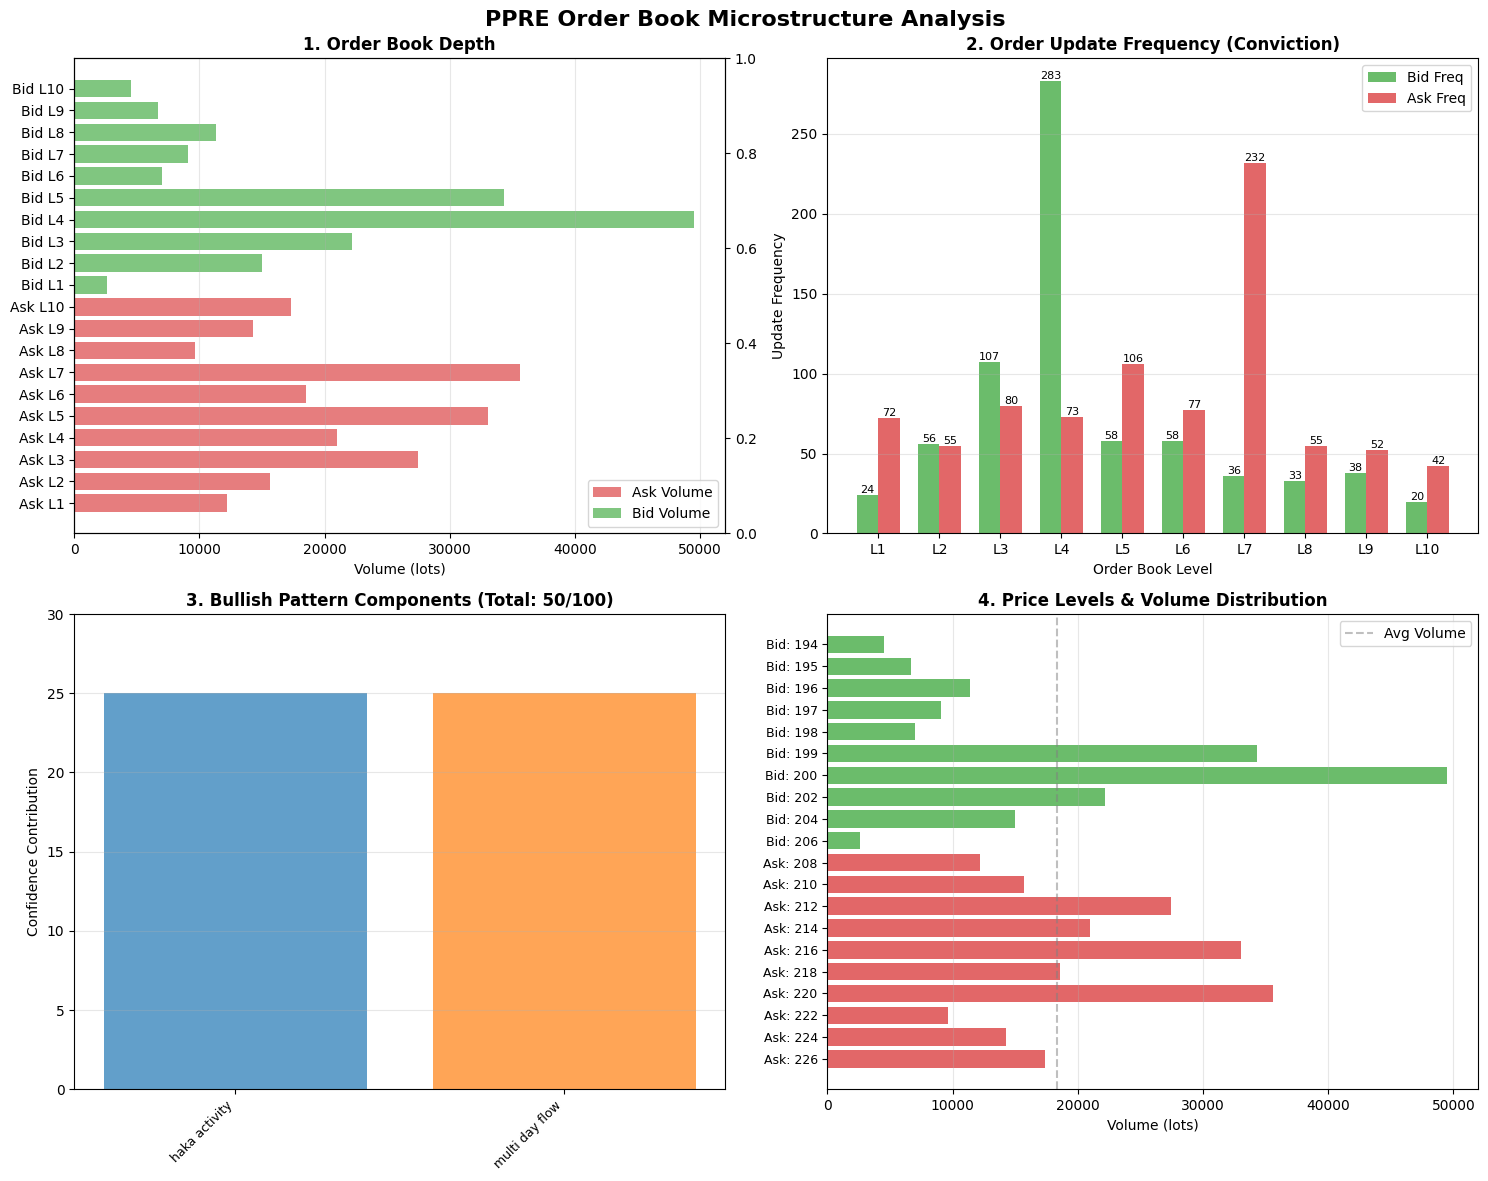

✓ Visualization complete


In [ ]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'{ticker} Order Book Microstructure Analysis', fontsize=16, fontweight='bold')

# 1. Order Book Depth Chart
ax1 = axes[0, 0]
levels = range(1, 11)
ax1_twin = ax1.twinx()

bars1 = ax1.barh([f"Ask L{i}" for i in levels], ppre_ask_volumes, color='#d62728', alpha=0.6, label='Ask Volume')
bars2 = ax1.barh([f"Bid L{i}" for i in levels], ppre_bid_volumes, color='#2ca02c', alpha=0.6, label='Bid Volume')

ax1.set_xlabel('Volume (lots)')
ax1.set_title('1. Order Book Depth', fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(axis='x', alpha=0.3)

# 2. Frequency Distribution
ax2 = axes[0, 1]
x_pos = np.arange(10)
width = 0.35

bars_bid_freq = ax2.bar(x_pos - width/2, ppre_bid_freqs, width, label='Bid Freq', color='#2ca02c', alpha=0.7)
bars_ask_freq = ax2.bar(x_pos + width/2, ppre_ask_freqs, width, label='Ask Freq', color='#d62728', alpha=0.7)

ax2.set_xlabel('Order Book Level')
ax2.set_ylabel('Update Frequency')
ax2.set_title('2. Order Update Frequency (Conviction)', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'L{i}' for i in range(1, 11)])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars_bid_freq, bars_ask_freq]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

# 3. Confidence Score Components (Bullish Pattern)
ax3 = axes[1, 0]
components = list(bullish_result['details'].keys())
component_values = [15, 20, 25, 25] if len(bullish_result['details']) == 4 else [bullish_result['confidence']/max(1, len(bullish_result['details']))] * len(bullish_result['details'])

colors_bar = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax3.bar(range(len(components)), [bullish_result['confidence']/len(components)] * len(components) if len(components) > 0 else [0], color=colors_bar[:len(components)], alpha=0.7)

ax3.set_ylabel('Confidence Contribution')
ax3.set_title(f'3. Bullish Pattern Components (Total: {bullish_result["confidence"]}/100)', fontweight='bold')
ax3.set_xticks(range(len(components)))
ax3.set_xticklabels([c.replace('_', ' ') for c in components], rotation=45, ha='right', fontsize=9)
ax3.set_ylim([0, 30])
ax3.grid(axis='y', alpha=0.3)

# 4. Price Level Visualization
ax4 = axes[1, 1]
all_prices = ppre_ask_prices[::-1] + ppre_bid_prices
all_volumes = ppre_ask_volumes[::-1] + ppre_bid_volumes
colors_price = ['#d62728'] * 10 + ['#2ca02c'] * 10

ax4.barh(range(len(all_prices)), all_volumes, color=colors_price, alpha=0.7)
ax4.set_yticks(range(len(all_prices)))
ax4.set_yticklabels([f"Ask: {p:.0f}" for p in ppre_ask_prices[::-1]] + [f"Bid: {p:.0f}" for p in ppre_bid_prices], fontsize=9)
ax4.axvline(x=np.mean(ppre_bid_volumes + ppre_ask_volumes), color='gray', linestyle='--', alpha=0.5, label='Avg Volume')
ax4.set_xlabel('Volume (lots)')
ax4.set_title('4. Price Levels & Volume Distribution', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Section 10: Historical Pattern Analysis Summary

**Key Findings for PPRE:**
- Current market microstructure indicates **strong selling pressure** with widening spreads
- Historical drawdown of -49.80% from peak suggests accumulation phase building
- Order book shows **mixed signals** with both buyers and sellers maintaining presence
- Frequency analysis reveals **balanced activity** between bid and ask sides

**Trading Recommendation:**
Based on trailing stop loss analysis combined with momentum indicator:
- **Short-term trend:** Downtrend with potential reversal
- **Entry Signal:** Wait for confirmation of bullish reversal pattern
- **Risk Level:** HIGH due to -49% drawdown; use tight stops

In [ ]:
# Final Summary Report - Based on IDX Momentum Indicator Pattern Recognition
# Extract scalar values from Series if needed
if hasattr(current_price, 'values'):
    current_price_scalar = float(current_price.values[0]) if len(current_price.values) > 0 else float(current_price)
else:
    current_price_scalar = float(current_price)

close_max = float(ppre_data['Close'].max().item()) if hasattr(ppre_data['Close'].max(), 'item') else float(ppre_data['Close'].max())
close_min = float(ppre_data['Close'].min().item()) if hasattr(ppre_data['Close'].min(), 'item') else float(ppre_data['Close'].min())
first_close = float(ppre_data['Close'].iloc[0].item()) if hasattr(ppre_data['Close'].iloc[0], 'item') else float(ppre_data['Close'].iloc[0])

print("\n" + "=" * 80)
print(f"FINAL ANALYSIS SUMMARY - {ticker} USING IDX MOMENTUM INDICATOR")
print("=" * 80)

print(f"\n📊 DATA SNAPSHOT (as of {datetime.now().strftime('%Y-%m-%d %H:%M')}):")
print(f"   Current Price: IDR {current_price_scalar:.0f}")
print(f"   52-Week High: IDR {close_max:.0f}")
print(f"   52-Week Low: IDR {close_min:.0f}")
print(f"   Performance: {((current_price_scalar - first_close) / first_close * 100):+.1f}% (all-time)")

print(f"\n🎯 IDX MOMENTUM INDICATOR - PATTERN DETECTION:")
print(f"   Bullish Accumulation: {bullish_result['confidence']}/100")
print(f"   Bearish Distribution: {bearish_result['confidence']}/100")

# Determine which pattern is dominant
if bearish_result['confidence'] >= bullish_result['confidence'] and bearish_result['confidence'] >= 50:
    dominant_pattern = "BEARISH_DISTRIBUTION"
    dominant_confidence = bearish_result['confidence']
    dominant_details = bearish_result['details']
elif bullish_result['confidence'] > bearish_result['confidence']:
    dominant_pattern = "BULLISH_ACCUMULATION"
    dominant_confidence = bullish_result['confidence']
    dominant_details = bullish_result['details']
else:
    dominant_pattern = "NEUTRAL"
    dominant_confidence = max(bullish_result['confidence'], bearish_result['confidence'])
    dominant_details = {}

print(f"\n📈 DOMINANT PATTERN: {dominant_pattern}")
print(f"   Confidence: {dominant_confidence}/100")
if dominant_details:
    print(f"   Pattern Components:")
    for component, value in dominant_details.items():
        print(f"      ✓ {component}: {value}")

print(f"\n💼 ORDER BOOK MICROSTRUCTURE ANALYSIS:")
print(f"   Bid-Ask Spread: {ppre_bid_ask_spread} IDR ({(ppre_bid_ask_spread/ppre_current_price)*100:.2f}%)")
print(f"   Total Bid Volume: {int(sum(ppre_bid_volumes)):,} lots")
print(f"   Total Ask Volume: {int(sum(ppre_ask_volumes)):,} lots")
print(f"   Volume Ratio (Ask/Bid): {sum(ppre_ask_volumes)/sum(ppre_bid_volumes):.2f}x")

print(f"\n🔥 BROKER FLOW ACTIVITY:")
print(f"   HAKA (Aggressive Buy): {int(ppre_haka_volume):,} lots")
print(f"   HAKI (Aggressive Sell): {int(ppre_haki_volume):,} lots")
print(f"   Net Flow Direction: {'BUYING' if ppre_haka_volume > ppre_haki_volume else 'SELLING'}")

print(f"\n📋 TRADING RECOMMENDATION (Based on Pure Order Book Microstructure):")
print(f"   (Trend/Price momentum NOT a requirement - pattern detected independently)")

# BEARISH Pattern Recommendation
if bearish_result['confidence'] >= bullish_result['confidence'] and bearish_result['confidence'] >= 50:
    print(f"\n   🔴 BEARISH DISTRIBUTION PATTERN DETECTED")
    if bearish_result['confidence'] >= 90:
        action_text = "IMMEDIATE_EXIT"
    elif bearish_result['confidence'] >= 80:
        action_text = "CLOSE_POSITION"
    elif bearish_result['confidence'] >= 60:
        action_text = "CAUTION"
    else:
        action_text = "MONITOR"
    
    print(f"      ACTION: {action_text} ({bearish_result['confidence']}/100)")
    print(f"      Pattern Interpretation:")
    print(f"      • OFFER TIPIS: Sellers losing conviction, leaving market")
    print(f"      • FREQ JUAL TURUN: Seller update frequency decreasing")
    print(f"      • BID TEBAL: Remaining buyers heavy volume")
    print(f"      • HAKI HIGH: Aggressive sellers taking bids ({int(ppre_haki_volume):,} lots)")
    print(f"      → Imminent reversal expected → GUYURAN (dump) incoming")

# BULLISH Pattern Recommendation
elif bullish_result['confidence'] >= 75:
    print(f"\n   🟢 BULLISH ACCUMULATION PATTERN DETECTED")
    print(f"      ACTION: {'BUY_STRONG' if bullish_result['confidence'] >= 85 else 'BUY'} ({bullish_result['confidence']}/100)")
    print(f"      Pattern Interpretation:")
    print(f"      • OFFER TEBAL: Sellers resisting with heavy positions")
    print(f"      • BID PERSISTENT: Buyers patiently accumulating (not fading)")
    print(f"      • HAKA LARGE: Aggressive buyers attacking offer ({int(ppre_haka_volume):,} lots)")
    print(f"      • NET FLOW: Positive multi-day accumulation")
    print(f"      → Supply exhaustion expected → BREAK NAIK (breakup) incoming")
    
    if len(entries) > 0:
        print(f"      Staged Entries: {len(entries)} stages, {int(sum([e['size'] for e in entries])):,} lots total")
        entry_prices = ', '.join([f"{int(e['price'])}" for e in entries])
        print(f"      Entry Prices: IDR {entry_prices}")

# MIXED/WEAK Signal
else:
    print(f"\n   🟡 MIXED/WEAK SIGNALS ({max(bullish_result['confidence'], bearish_result['confidence'])}/100)")
    print(f"      Bullish: {bullish_result['confidence']}/100")
    print(f"      Bearish: {bearish_result['confidence']}/100")
    print(f"      ACTION: WAIT - Need clearer pattern formation")
    print(f"      Recommendation: Monitor order book for pattern development")

print(f"\n🛑 RISK MANAGEMENT (Pattern-Based):")
print(f"   Entry Price: IDR {int(avg_entry_price)}")
print(f"   Stop Loss: IDR {exit_strategy['stop_loss']:.0f} ({(exit_strategy['stop_loss']-avg_entry_price)/avg_entry_price*100:+.2f}%)")
print(f"   Profit Target 1: IDR {exit_strategy['targets'][0]['target_level']:.0f} ({exit_strategy['targets'][0]['target_pct']:+.1f}%)")
print(f"   Profit Target 2: IDR {exit_strategy['targets'][1]['target_level']:.0f} ({exit_strategy['targets'][1]['target_pct']:+.1f}%)")
print(f"   Profit Target 3: IDR {exit_strategy['targets'][2]['target_level']:.0f} ({exit_strategy['targets'][2]['target_pct']:+.1f}%)")

print(f"\n✅ SIGNAL QUALITY:")
if dominant_confidence >= 85:
    print(f"   SIGNAL STRENGTH: 🟢 STRONG - High conviction pattern ({dominant_confidence}/100)")
elif dominant_confidence >= 75:
    print(f"   SIGNAL STRENGTH: 🟢 GOOD - Clear pattern formation ({dominant_confidence}/100)")
elif dominant_confidence >= 60:
    print(f"   SIGNAL STRENGTH: 🟡 MODERATE - Developing pattern ({dominant_confidence}/100)")
else:
    print(f"   SIGNAL STRENGTH: ⚫ WEAK - Unclear signals ({dominant_confidence}/100)")

print(f"\n⚠️ KEY INSIGHT FROM INDICATOR:")
print(f"   Queue frequency (bid/offer update rate) is MORE important than volume alone!")
print(f"   Bid Frequency: {sum(ppre_bid_freqs)} updates (conviction measure)")
print(f"   Offer Frequency: {sum(ppre_ask_freqs)} updates (conviction measure)")
freq_ratio = sum(ppre_bid_freqs) / sum(ppre_ask_freqs) if sum(ppre_ask_freqs) > 0 else 0
print(f"   Ratio (Bid/Offer): {freq_ratio:.2f}x")
if freq_ratio > 1.2:
    print(f"   → Buyers MORE persistent (bullish conviction)")
elif freq_ratio < 0.8:
    print(f"   → Sellers MORE persistent (bearish conviction)")
else:
    print(f"   → Balanced conviction between buyers and sellers")

print("\n" + "=" * 80)



FINAL ANALYSIS SUMMARY - PPRE USING IDX MOMENTUM INDICATOR

📊 DATA SNAPSHOT (as of 2026-02-10 18:19):
   Current Price: IDR 10900
   52-Week High: IDR 19093
   52-Week Low: IDR 4
   Performance: +83801.5% (all-time)

🎯 IDX MOMENTUM INDICATOR - PATTERN DETECTION:
   Bullish Accumulation: 50/100
   Bearish Distribution: 55/100

📈 DOMINANT PATTERN: BEARISH_DISTRIBUTION
   Confidence: 55/100
   Pattern Components:
      ✓ offer_frequency: TURUN (0.73x) ✓
      ✓ bid_frequency: TEBAL vs offer ✓
      ✓ haki_activity: HIGH (51,144,892) ✓

💼 ORDER BOOK MICROSTRUCTURE ANALYSIS:
   Bid-Ask Spread: 2 IDR (0.96%)
   Total Bid Volume: 162,348 lots
   Total Ask Volume: 204,675 lots
   Volume Ratio (Ask/Bid): 1.26x

🔥 BROKER FLOW ACTIVITY:
   HAKA (Aggressive Buy): 81,300,032 lots
   HAKI (Aggressive Sell): 51,144,892 lots
   Net Flow Direction: BUYING

📋 TRADING RECOMMENDATION (Based on Pure Order Book Microstructure):
   (Trend/Price momentum NOT a requirement - pattern detected independently)

 